In [2]:
"""
If Using Google Colab:
from google.colab import drive
drive.mount('/content/drive')
"""

"\nIf Using Google Colab:\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

# <span style="color:blue">Business Understanding</span>
We are the data science team for an investment consulting company. Our problem is that we want to make use of social media data to inform investing advice based on predicting sentiment of text that includes a given brand's name and/or products. Our first foray into this work is to build a model that predicts the sentimet of tweets on Twitter/ X, using the categories positive, negative or neutral. Our predictors include a brand-name (Apple or Google) and product name (Android, iPhone, etc). Our goal is to develop a high-accuracy model to gauge brand satisfaction. We'll use the sentiment of the tweet to compare the proportion of positive reviews associated with Apple products versus Google products. The creation of this model can then be generalized by training it on a wider range of data from social media in order to gauge brand satisfaction segmented by attributes such as event hashtags, top brand influencers or how sentiment for a given brand, product, or product model has evolved over time.

# <span style="color:blue">Data Understanding</span>
* The subject of our Twitter/ X data centers on the 2013 SXSW conference [here](https://schedule.sxsw.com/2013/events/grid?day=8)
  * South by Southwest (SXSW) is a multi-conference event of interactive media, music and film that occurs in Austin, Texas each year in March. Each tweet in our data mentions either Apple products, Google products, or both as well as specific products under those brands.
* We sourced our data from data.world which can be found [here](https://data.world/crowdflower/brands-and-product-emotions)

### <span style='color:blue'>Number of Instances</span>:
- `9,093`


### <span style="color:blue">Features</span>:
* **`tweet_text`**
  * Text string of entire tweet
* **`emotion_in_tweet_is_directed_at`**
  * Product and/or Brand mentioned in tweet
* **`is_there_an_emotion_directed_at_a_brand_or_product`**
  * This is our predictor value
  * Values for sentiment of tweet:
    * `Positive Emotion`
    * `Negative Emotion`
    * `No emotion toward brand or product`
    * `I can't tell`

#### <span style="color:blue">Apple Products mentioned in tweet text</span>
* `apple`                             
* `ipad`                               
* `iPad`
* `iphone`                            
* `Apple`
* `iPad or iPhone App`
* `iPhone`
* `Other Apple product or service`

#### <span style="color:blue">Google Products mentioned in tweet text</span>               
* `Google`                             
* `android`                            
* `google`                              
* `Other Google product or service`    
* `Android App`                        
* `Android`


#### <span style="color:blue">Products not clearly Apple or Google were tagged `Unknown`</span>


#### Claire Note: Could just say there were blanks or we couldn't find any Apple/Google keywords in some tweets.

# <span style="color:blue">Import Libraries</span>

In [3]:
### Prior to code execution, automatically reloads modules.
%load_ext autoreload
%autoreload 2

### Core Data Science Packages:
import numpy as np
import pandas as pd

### Operating System Interaction:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

### Data Handling:
import unicodedata
import string
import re
# For non-existant key, returns default value
from collections import defaultdict

### Natural Language Processing:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams
# NLTK word corpus lists:
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

### Models:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

### Data Preprocessing:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

### Model Validation:
from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold

### Model Tuning:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Keras:
import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from keras import backend as K

### Tensorflow:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import datasets, layers, models, callbacks

### Data Visualization:
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/claire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/claire/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/claire/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/claire/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/claire/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


: 

### Install additional libraries if needed:

In [ ]:
 #!pip install wordcloud

In [ ]:
 #!pip install keras-tuner

In [ ]:
#!pip install tensorflow

# Load Data:

In [ ]:
### For Loading Data into Google Colab from Google Drive:

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/raw_data/judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')

In [ ]:
# data = pd.read_csv("raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

# Data Cleaning:

### Preview Data:
- Preliminary observations:
  - Row #6 is missing the text of the tweet, so we can drop this row.
  - A tweet can mention multiple products
  - Some rows have a missing value in `emotion_in_tweet_is_directed_at` -- yet do mention a product in text of tweet. These missing values could be filled using string matching.
  - Unimportant words:
    - There are special characters, hyperlinks, and redundant sequences of characters such as #SXSW and mentions prefixed by `@` which may be beneficial to remove as they do not add to signal for predicting sentiment.

In [ ]:
# Preview Data:
data.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


### Drop row where `tweet_text` = `NaN`

In [ ]:
# Check that there's only one row where tweet_text is missing:
data.tweet_text.isna().sum()


1

In [ ]:
# Drop that row:
data.dropna(subset=['tweet_text'], inplace=True)

### Drop Duplicates:
- We observed below that there are 9,092 total rows, and only 9,065 *unique* values for `tweet_text` - thus there are duplicates we need to drop

In [ ]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9092
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5388


In [ ]:
# Drop where tweet_text is duplicated:
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [ ]:
# Check .describe() again:
# We now have the same number of instances as unique values
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9065,3280,9065
unique,9065,9,4
top,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPad,No emotion toward brand or product
freq,1,943,5372


### Rename columns for readability:
- `emotion_in_tweet_is_directed_at`
  - New Column Name = `brand`
- `is_there_an_emotion_directed_at_a_brand_or_product`
  - New Column Name = `sentiment`

In [ ]:
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [ ]:
# Preview Data:
data.head()

,tweet_text,brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Create one-hot-encoded columns for categorical variables:
- Because the `brand` column is missing values in some instances (NaN when in fact `iPhone` exists in the `tweet_text` for example), we'll create a column for each product and brand, based on searching `tweet_text` for these strings: "Apple", "Google", "iPad", "iPhone", "Android", "goog"

#### Create Columns for each keyword, where value = keyword

In [ ]:
# Define keywords to search for
keywords = ["Apple", "Google", "iPad", "iPhone", "Android", "goog"]

# Create a new column for each keyword, where value = keyword if found in tweet_text
for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)



#### Create `Product` column
- In the case of a tweet mentioning both Apple and Google products, we defaulted to Apple as a heuristic method - we don't believe this skewed the representation of brands in a significant way.

In [ ]:
# Create product column with values "Apple" or "Google" by grouping which keywords belong to a given brand:
data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any()
                                                                                else 'Google' if x[['Google', 'Android']].any()
                                                                                else None, axis=1)

In [ ]:
# Preview Results
data.head()

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android,goog,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN,iPhone,NaN,NaN,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,iPad,iPhone,NaN,NaN,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,iPad,NaN,NaN,NaN,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN,iPhone,NaN,NaN,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,Google,NaN,NaN,NaN,Goog,Google


#### Gauge overall balance of Apple vs. Google representation in `tweet_text`
- Apple is mentioned in about 67% of the tweets





In [ ]:
data['product'].value_counts()

Apple     5517
Google    2764
Name: product, dtype: int64

#### Drop where `product` = `NaN` as this is where `tweet_text` did not contain any of our Apple or Google keywords
- This will drop about 8.6% of rows

In [ ]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [ ]:
#Dropped to focus on tweets where google and apple where mentioned
data.dropna(subset=['product'], inplace=True)

### Clean `sentiment` Column:

#### Create "Neutral" category
- Groups "I can't tell" and "No emotion toward brand or product" into "Neutral"

#### Convert text to numbers:
- Negative: 0
- Neutral: 1
- Positive: 2

In [ ]:
# Create "Neutral emotion" category in sentiment column:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [ ]:
# Convert string values to integer in sentiment column:
target_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(target_to_replace)

In [ ]:
# Most sentiments are neutral, followed by positive.
data['sentiment'].value_counts()

1    4783
2    2930
0     568
Name: sentiment, dtype: int64

In [ ]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

- Claire Note: not sure why we convert this to string

In [ ]:
data['product'] = data['product'].astype(str)

# NLP Data Pre-Processing:

In [ ]:

sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm","rt" "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [ ]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):

    #lemmatized, parsed for stopwords, made lowercase,and stripped of punctuation and numbers.
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Remove mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 2]  # Remove tokens with length <= 1
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
 # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
# Extracting important features from our data
corpse = data.tweet_text
target = data.sentiment
product = data.product

In [ ]:
token_text = [doc_preparer(doc,sw) for doc in corpse]

In [ ]:
token_text

NameError: name 'token_text' is not defined

In [ ]:
# Convert the 'product' column to strings
data['product'] = data['product'].astype(str)

# Concatenate the "corpse" and "product" columns
data['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

# Assign the concatenated text to X
X = data['text_with_product']

# Assign the target labels to y
y = data['sentiment']

# Exploratory Data Analysis



In [ ]:
# Tokenize text by words for each row in the 'processed_text' column
data['tokenized_text'] = data['text_with_product'].apply(lambda x: word_tokenize(x))

In [ ]:
# Check the number of words by summing the lengths of the tokenized lists
total_words = data['tokenized_text'].apply(len).sum()
total_words

74661

In [ ]:
# Combine all the tokenized words into a single list
all_words = [word for tokenized_text in data['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist = FreqDist(all_words)

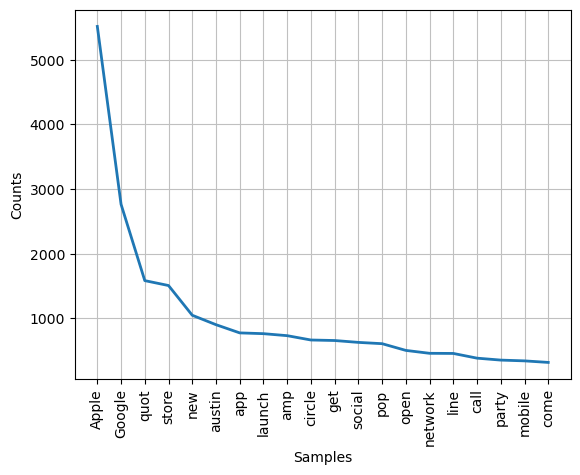

In [ ]:

#Plot the 10 most common words
freq_dist.plot(20)
plt.show();

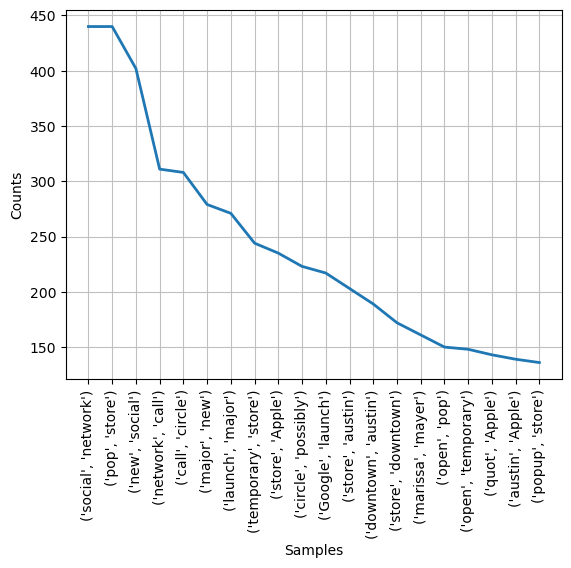

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
bigrams = nltk.bigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

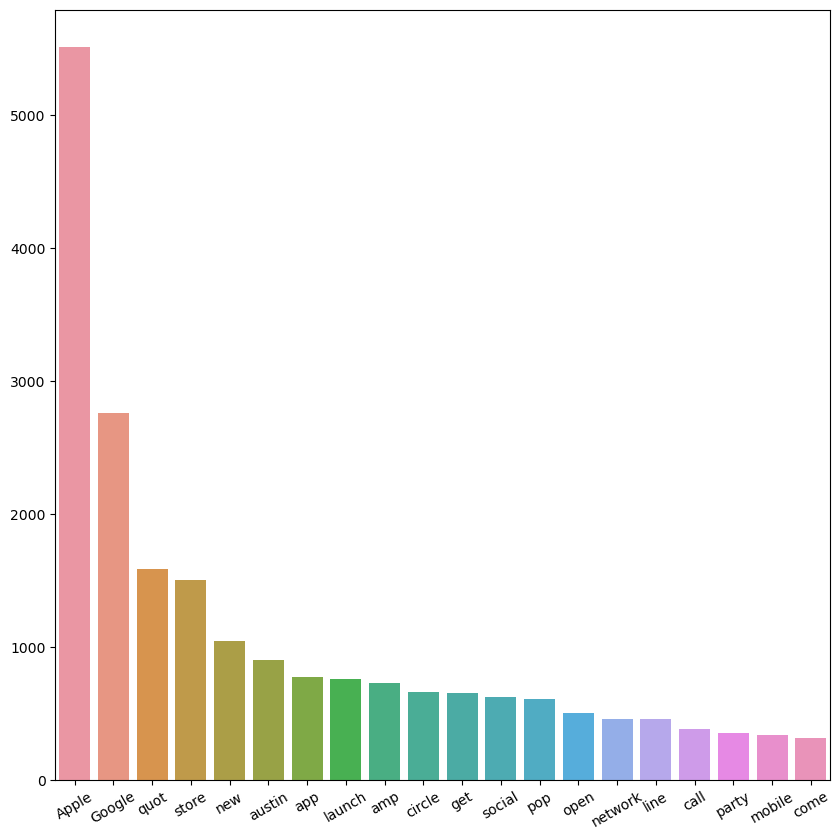

In [ ]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(all_words).most_common(20)

# Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

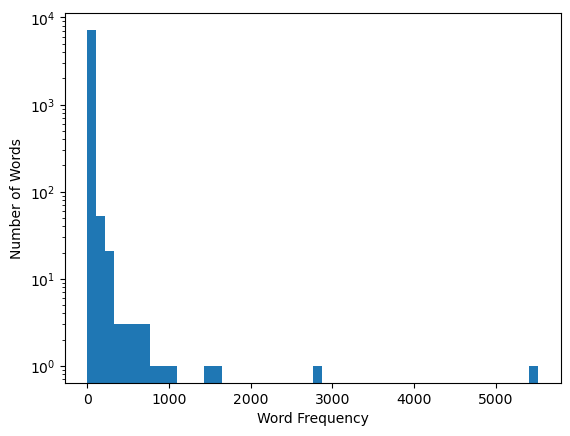

In [ ]:
# Vectorize the text
vectorizer = CountVectorizer()
corpse = ()
X = vectorizer.fit_transform(data['text_with_product'])

# Sum the word frequencies
word_freq = X.sum(axis=0)

# Convert to a numpy array and flatten
word_freq = word_freq.A1

# Plot the distribution
plt.hist(word_freq, bins=50, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show();

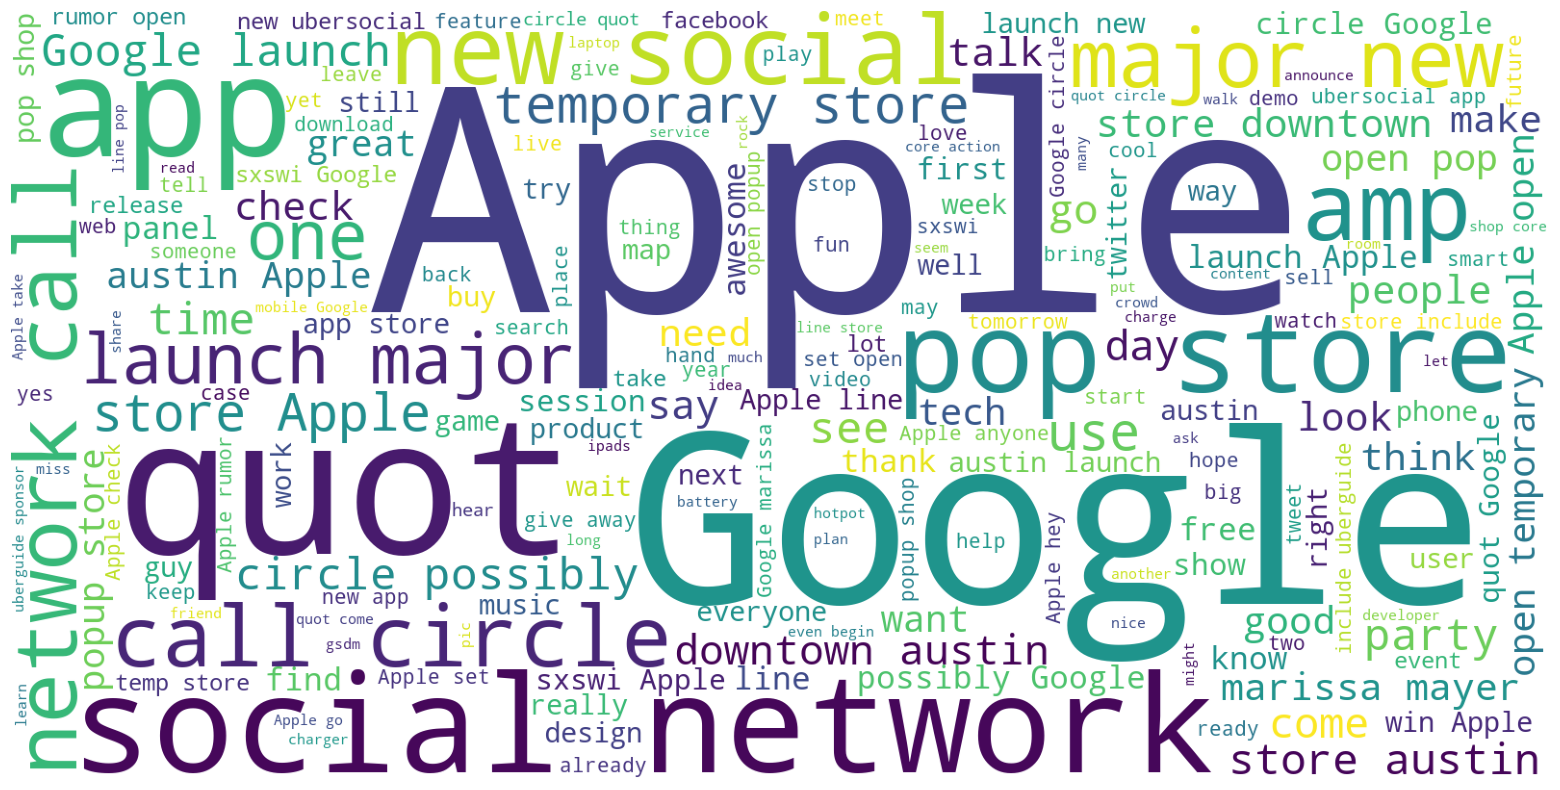

<Figure size 640x480 with 0 Axes>

In [ ]:
#Convert word list to a single string
words_string = " ".join(all_words)

#generating the wordcloud
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(words_string)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show();

plt.savefig("cloudword.png")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [ ]:
#ui
#lt
#rt

# Baseline Model, MultinomialNB

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))

X_t_vec = tfidf.fit_transform(X_t)

X_val_vec = tfidf.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6314154919339979

In [ ]:
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.657437218287186

In [ ]:
y_t_mnb = mnb.predict(X_t_vec)
y_t_pred_mnb= mnb.predict(X_val_vec)

print("Accuracy:")
train_accuracy = accuracy_score(y_t, y_t_mnb)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_val, y_t_pred_mnb)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_t, y_t_mnb)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_val, y_t_pred_mnb)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.8200558299334335
Test Accuracy: 0.657437218287186

Balanced Accuracy:
Train Accuracy: 0.5724864220076644
Test Accuracy: 0.4076328192297774


/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.65      0.95      0.77       924
           2       0.73      0.27      0.40       526

    accuracy                           0.66      1553
   macro avg       0.46      0.41      0.39      1553
weighted avg       0.63      0.66      0.59      1553



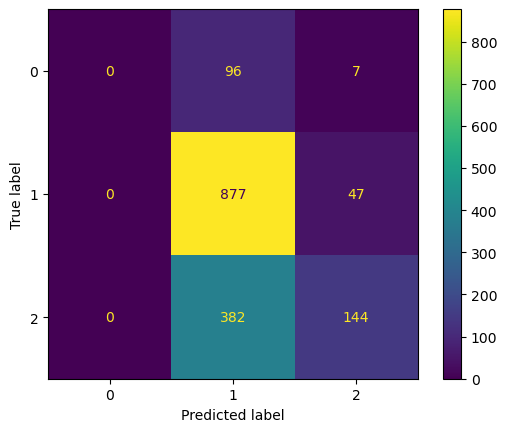

In [ ]:
print(classification_report(y_val, y_t_pred_mnb))
cm = confusion_matrix(y_val, y_t_pred_mnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Balanced MultinomialNB

In [ ]:
# Create an instance of RandomOverSampler
oversampler = RandomOverSampler()

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X_t_vec, y_t)



# Create and fit the MultinomialNB model
mnb1 = MultinomialNB()
mnb1.fit(X_resampled, y_resampled)

MultinomialNB()

In [ ]:
# y_t_pred_mnb1 = mnb1.predict(X_t_vec)

In [ ]:
y_t_mnb1 = mnb1.predict(X_t_vec)
y_t_pred_mnb1 = mnb1.predict(X_val_vec)

print("Accuracy:")
train_accuracy = accuracy_score(y_t, y_t_mnb1)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_val, y_t_pred_mnb1)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_t, y_t_mnb1)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_val, y_t_pred_mnb1)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.9018681554648915
Test Accuracy: 0.6123631680618158

Balanced Accuracy:
Train Accuracy: 0.9243901612446194
Test Accuracy: 0.5829689473696266


              precision    recall  f1-score   support

           0       0.26      0.52      0.35       103
           1       0.74      0.64      0.68       924
           2       0.56      0.59      0.57       526

    accuracy                           0.61      1553
   macro avg       0.52      0.58      0.54      1553
weighted avg       0.65      0.61      0.62      1553



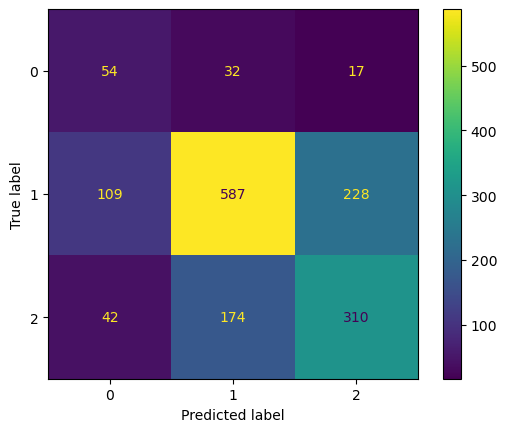

In [ ]:
print(classification_report(y_val, y_t_pred_mnb1))
cm = confusion_matrix(y_val, y_t_pred_mnb1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Smote with MultinomialNB

# LogisticRegression

In [ ]:
lr =  LogisticRegression(random_state =42, multi_class='multinomial', solver='saga', class_weight='balanced', n_jobs=-1)

lr.fit(X_t_vec, y_t)
y_hat = lr.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.6697035972529065

In [ ]:
y_t_lr = lr.predict(X_t_vec)
y_t_pred_lr= lr.predict(X_val_vec)

print("Accuracy:")
train_accuracy = accuracy_score(y_t, y_t_lr)
print("Train Accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_val, y_t_pred_lr)
print("Test Accuracy:", test_accuracy)

print("\nBalanced Accuracy:")
train_accuracy = balanced_accuracy_score(y_t, y_t_lr)
print("Train Accuracy:", train_accuracy)

test_accuracy = balanced_accuracy_score(y_val, y_t_pred_lr)
print("Test Accuracy:", test_accuracy)

Accuracy:
Train Accuracy: 0.6691002791496672
Test Accuracy: 0.4713457823567289

Balanced Accuracy:
Train Accuracy: 0.7780168563909768
Test Accuracy: 0.5650605797990346


              precision    recall  f1-score   support

           0       0.13      0.76      0.23       103
           1       0.79      0.40      0.53       924
           2       0.57      0.53      0.55       526

    accuracy                           0.47      1553
   macro avg       0.50      0.57      0.44      1553
weighted avg       0.67      0.47      0.52      1553



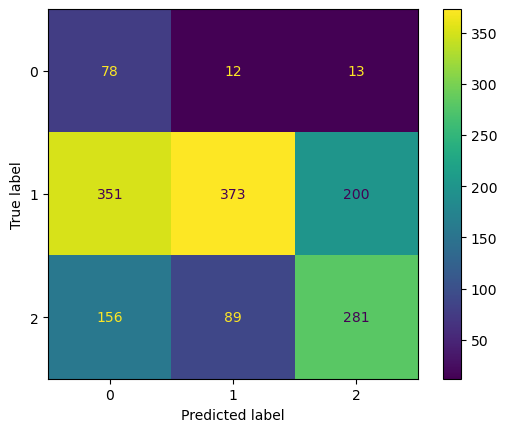

In [ ]:
print(classification_report(y_val, y_t_pred_lr))
cm = confusion_matrix(y_val, y_t_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# CNN

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(28, 28, 1)))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# RNN

In [ ]:
X_t_vec_dense = X_t_vec.toarray()
X_val_vec_dense = X_val_vec.toarray()

In [ ]:
K.clear_session()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_t), y=y_t)

# Define the RNN model
embedding_dim = 200
lstm_units = 32  #
num_classes = len(np.unique(y_t))
batch_size = 32
epochs = 20

model = Sequential()
model.add(Embedding(input_dim=X_t_vec_dense.shape[1], output_dim=embedding_dim, input_length=X_t_vec_dense.shape[1]))
model.add(LSTM(units=lstm_units))
model.add(Dense(units=num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

unique_classes = np.unique(y_t)
class_weights_dict = {}
for class_index in unique_classes:
    class_weights_dict[class_index] = class_weights[class_index]

model.fit(X_t_vec_dense, y_t, batch_size=batch_size, epochs=epochs, validation_data=(X_val_vec_dense, y_val), class_weight=class_weights_dict)

Epoch 1/20
146/146 [==============================] - 309s 2s/step - loss: 1.1030 - accuracy: 0.2938 - val_loss: 1.1001 - val_accuracy: 0.0663
Epoch 2/20
146/146 [==============================] - 309s 2s/step - loss: 1.0996 - accuracy: 0.4011 - val_loss: 1.1417 - val_accuracy: 0.0663
Epoch 3/20
146/146 [==============================] - 309s 2s/step - loss: 1.1002 - accuracy: 0.2424 - val_loss: 1.1041 - val_accuracy: 0.0663
Epoch 4/20
146/146 [==============================] - 308s 2s/step - loss: 1.0998 - accuracy: 0.3313 - val_loss: 1.1169 - val_accuracy: 0.3387
Epoch 5/20
146/146 [==============================] - 310s 2s/step - loss: 1.0993 - accuracy: 0.2688 - val_loss: 1.0989 - val_accuracy: 0.5950
Epoch 6/20
146/146 [==============================] - 311s 2s/step - loss: 1.0991 - accuracy: 0.3629 - val_loss: 1.1015 - val_accuracy: 0.3387
Epoch 7/20
146/146 [==============================] - 317s 2s/step - loss: 1.0991 - accuracy: 0.2948 - val_loss: 1.1050 - val_accuracy: 0.0663

KeyboardInterrupt: 

In [ ]:
# Define the model-building function
K.clear_session()
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=X_t_vec_dense.shape[1], output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50), input_length=X_t_vec_dense.shape[1]))
    model.add(LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64)))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)

# Perform the hyperparameter search
tuner.search(X_t_vec_dense, y_t, validation_data=(X_val_vec_dense, y_val), epochs=20, batch_size=32)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)


Trial 1 Complete [00h 00m 02s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 02s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
50                |100               |embedding_dim
128               |256               |lstm_units

Epoch 1/10
146/146 [==============================] - 536s 4s/step - loss: 1.0371 - accuracy: 0.5540 - val_loss: 0.9642 - val_accuracy: 0.5950
Epoch 2/10
146/146 [==============================] - 479s 3s/step - loss: 0.8832 - accuracy: 0.5680 - val_loss: 0.8557 - val_accuracy: 0.5950
Epoch 3/10
 32/146 [=====>........................] - ETA: 6:30 - loss: 0.9441 - accuracy: 0.5645

KeyboardInterrupt: 

In [ ]:
#How to pull a specific predictor out

In [ ]:
# Our baseline model is not bad, performance at 0.689 with TFIDF

In [ ]:
# Grid search and Modeling

In [ ]:
# # Define the MNB pipeline
# nbpipe = Pipeline([
#     ('vect', TfidfVectorizer(ngram_range=(1, 2))),
#     ('clf', MultinomialNB())
# ])

# # Fit the pipeline to the training data
# nbpipe.fit(X_t, y_t)

In [ ]:

# # Specify hyperparameters and their distributions
# parameters = {
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'vect__max_df': [0.5, 0.75, 1.0],
#     'vect__min_df': [0.01, 0.05, 0.1],
#     'vect__max_features': [500, 1000, 20],
#     'vect__stop_words': [None, 'english'],
#     'vect__analyzer': ['word', 'char', 'char_wb'],
#     'clf__alpha': [0.0, 0.5, 1.0, 2.0],
#     'clf__fit_prior': [True, False]
# }

In [ ]:
# Instantiate GridSearchCV object using the lrpipe pipeline
# grid_search = GridSearchCV(nbpipe, parameters, n_jobs=-1, cv=5)

# # Fit on data
# grid_search.fit(X_t, y_t)

In [ ]:
# # Get the best parameters
# best_params = grid_search.best_params_
# best_params

In [ ]:
# y_t_gr = grid_search.predict(X_t)
# y_t_pred_gr= grid_search.predict(X_val)

# print("Accuracy:")
# train_accuracy = accuracy_score(y_t, y_t_gr)
# print("Train Accuracy:", train_accuracy)

# test_accuracy = accuracy_score(y_val, y_t_pred_gr)
# print("Test Accuracy:", test_accuracy)

# print("\nBalanced Accuracy:")
# train_accuracy = balanced_accuracy_score(y_t, y_t_gr)
# print("Train Accuracy:", train_accuracy)

# test_accuracy = balanced_accuracy_score(y_val, y_t_pred_gr)
# print("Test Accuracy:", test_accuracy)